In [1]:
## running once
%load_ext autoreload
%autoreload 2

In [39]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

from collections import namedtuple
from toolz.curried import *
import matplotlib.pyplot as plt

uberdir = "/home/xiucheng/data/uber-movement/"
nykjuly = os.path.join(uberdir, "movement-speeds-hourly-new-york-2019-7.csv.zip")
nykaugs = os.path.join(uberdir, "movement-speeds-hourly-new-york-2019-8.csv.zip")
nyksept = os.path.join(uberdir, "movement-speeds-hourly-new-york-2019-9.csv.zip")

In [6]:
from util import *

In [4]:
city = load_mdt_geometry("/home/xiucheng/Github/spatial-infer/data/new-york.geojson", 
                         quad_longisland)
print(city.shape)

(8291, 7)


<AxesSubplot:>

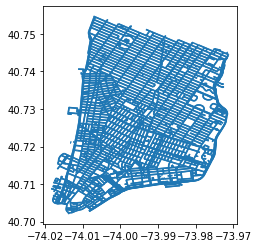

In [5]:
city.plot()

In [6]:
%%time
mdt_data = pd.read_csv(nykjuly)
print(mdt_data.shape)

(25365815, 13)
CPU times: user 50 s, sys: 1.81 s, total: 51.9 s
Wall time: 51.9 s


In [7]:
%%time
mdt_df = transform_mdt_dataframe(mdt_data, city, 0.1)

CPU times: user 21.4 s, sys: 1.54 s, total: 22.9 s
Wall time: 22.9 s


In [8]:
mdt_df.drop("speed_std", axis=1, inplace=True)

In [9]:
sids = mdt_df.reset_index().sid.unique()
print(len(sids))

1394


In [10]:
trn, val, tst, mean, std = split_trn_val_tst(mdt_df, True, keep_ratio=0.1)

In [11]:
print(trn.stack().shape[0])
print(tst.stack().shape[0])

91960
913025


In [12]:
x_trn = trn.values.reshape(len(sids), -1)
x_tst = tst.values.reshape(len(sids), -1)

In [13]:
x_trn.shape

(1394, 744)

In [145]:
pipe(np.logical_not(np.isnan(x_trn)).sum(axis=1) / x_trn.shape[1], np.mean)

0.08796917665571344

In [182]:
#idx = np.random.choice(np.arange(x_trn.shape[0]), 1000, replace=False)

In [14]:
def denorm(x, m, s):
    return x * s + m
x_tst = denorm(x_tst, mean.values[0], std.values[0])

In [15]:
from fancyimpute import SimpleFill, KNN, SoftImpute, BiScaler, MatrixFactorization

In [16]:
# x_knn_s = KNN(k=3, verbose=False).fit_transform(x_trn_s)
# stat_knn = collect_entries(x_tst_s, x_knn_s)
# evaluated_message(stat_knn)

In [17]:
# %%time
# x_s = SimpleFill(fill_method='mean').fit_transform(x_trn_s)
# x_s = denorm(x_s, mean.values[0], std.values[0])

# stat_simp = collect_entries(x_tst_s, x_s)
# evaluated_message(stat_simp)

In [18]:
# %%time
# biscaler = BiScaler(verbose=False)
# x_trn_s_normalized = biscaler.fit_transform(x_trn_s)
# x_soft_s = SoftImpute(verbose=False).fit_transform(x_trn_s_normalized)
# x_soft_s = biscaler.inverse_transform(x_soft_s)

In [20]:
%%time
x = SoftImpute(verbose=False).fit_transform(x_trn)
x = denorm(x, mean.values[0], std.values[0])

CPU times: user 1min 41s, sys: 590 ms, total: 1min 42s
Wall time: 25.5 s


In [21]:
stat_soft = collect_entries(x_tst, x)
evaluated_message(stat_soft)
#' RMSE:   3.285 MAE:   2.226 Max Error:   50.72 MAEP:  0.1461'
#' RMSE:    3.14 MAE:   2.131 Max Error:   49.34 MAEP:  0.1425'

' RMSE:   4.902 MAE:    3.36 Max Error:   36.91 MAEP:  0.2763'